In [1]:
import os
import shutil
import glob
import datetime
import time
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# # Read raw PPG files as a list of dataframes and store them in a list
# def read_raw_ppg_files():
#     files = glob.glob('../prof_data/resteaze/*.csv')
#     df_list = []
#     for file in files:
#         df = pd.read_csv(file)
#         df_list.append(df)
#     return df_list


# data = read_raw_ppg_files()


In [3]:
# Read raw PPG files
data = pd.concat(map(pd.read_csv, glob.glob('../prof_data/resteaze/*.csv')))


In [4]:
all_df = data[[
    'unixTimes', 'accelerometerX', 'accelerometerY', 'accelerometerZ',
    'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'ledGreen', 'sleep_state'
]]

all_df = all_df[all_df['sleep_state'].notna()]
df = all_df.interpolate()

In [5]:
df

,unixTimes,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,sleep_state
0,1644991436679,NaN,NaN,NaN,NaN,NaN,NaN,2716.0,-1.0
1,1644991436719,74.0,335.0,3989.0,-162.0,-93.0,109.0,2711.5,-1.0
2,1644991436719,80.5,331.0,3988.5,-166.5,-65.0,123.0,2707.0,-1.0
3,1644991436759,87.0,327.0,3988.0,-171.0,-37.0,137.0,2704.5,-1.0
4,1644991436759,79.5,343.0,4003.5,-177.5,-24.0,134.0,2702.0,-1.0
...,...,...,...,...,...,...,...,...,...
1312000,1648123856516,-2191.0,164.0,3393.0,24.0,-233.0,58.0,7506.0,2.0
1312001,1648123856555,-2195.0,163.0,3401.0,6.0,-227.0,61.0,7506.0,2.0
1312002,1648123856588,-2197.0,163.0,3401.0,25.0,-223.0,64.0,7506.0,2.0
1312003,1648123856628,-2190.0,173.0,3405.0,19.0,-229.0,60.0,7506.0,2.0


In [6]:
# mdf = mdf.apply(lambda x: pd.Series(x.dropna().values))

df = df[df.sleep_state != -1].reset_index()


In [7]:
df = ((df + df.shift(-1)) / 2)[::2]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.dropna()

df

,index,unixTimes,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,sleep_state
0,12734.5,1.644992e+12,57.00,296.25,4021.00,-201.75,-47.75,99.00,2558.75,0
2,12736.5,1.644992e+12,29.00,302.50,4026.00,-226.25,-75.25,119.75,2548.75,0
4,12738.5,1.644992e+12,40.50,310.25,4031.00,-228.00,-108.25,113.25,2546.00,0
6,12740.5,1.644992e+12,53.50,310.00,4028.00,-224.50,-86.00,101.25,2545.25,0
8,12742.5,1.644992e+12,45.25,307.25,4026.75,-232.00,-86.25,116.50,2545.00,0
...,...,...,...,...,...,...,...,...,...,...
18364782,1311994.5,1.648124e+12,-2191.00,161.00,3397.00,12.50,-226.00,42.50,7492.00,1
18364784,1311996.5,1.648124e+12,-2189.50,157.50,3394.50,20.00,-222.50,61.00,7497.00,1
18364786,1311998.5,1.648124e+12,-2191.50,162.00,3393.00,20.00,-227.00,65.00,7502.50,1
18364788,1312000.5,1.648124e+12,-2193.00,163.50,3397.00,15.00,-230.00,59.50,7506.00,1


In [8]:
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from numpy import mean, sqrt, square, arange

# # RMS of accelerometer
# df['accelerometer'] = df[[
#     'accelerometerX', 'accelerometerY', 'accelerometerZ'
# ]].apply(lambda x: sqrt(square(x['accelerometerX']) + square(x['accelerometerY']) + square(x['accelerometerZ'])), axis=1)

# # RMS of gyroscope
# df['gyroscope'] = df[[
#     'gyroscopeX', 'gyroscopeY', 'gyroscopeZ'
# ]].apply(lambda x: sqrt(square(x['gyroscopeX']) + square(x['gyroscopeY']) + square(x['gyroscopeZ'])), axis=1)

# df = df.drop(columns=['accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ'])

In [9]:
#@title Bandpass Filter
from scipy.signal import butter, sosfilt, sosfreqz


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y


# apply bandpass filter

fs = 25
lowcut = 0.55
highcut = 3.0

df['ledGreen'] = butter_bandpass_filter(df['ledGreen'],
                                            lowcut,
                                            highcut,
                                            fs,
                                            order=3)


In [10]:
# data = df[['ledGreen','accelerometer','gyroscope','sleep_state']]
data = df

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9182396 entries, 0 to 18364790
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   index           float64
 1   unixTimes       float64
 2   accelerometerX  float64
 3   accelerometerY  float64
 4   accelerometerZ  float64
 5   gyroscopeX      float64
 6   gyroscopeY      float64
 7   gyroscopeZ      float64
 8   ledGreen        float64
 9   sleep_state     int32  
dtypes: float64(9), int32(1)
memory usage: 735.6 MB


In [12]:
# data.to_csv('prefinal_processed.csv')

## Process Segmentwise HR data

In [13]:
# data = pd.read_csv("prefinal_processed.csv", index_col=0)

In [14]:
data

,index,unixTimes,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,sleep_state
0,12734.5,1.644992e+12,57.00,296.25,4021.00,-201.75,-47.75,99.00,43.987752,0
2,12736.5,1.644992e+12,29.00,302.50,4026.00,-226.25,-75.25,119.75,243.038014,0
4,12738.5,1.644992e+12,40.50,310.25,4031.00,-228.00,-108.25,113.25,627.523616,0
6,12740.5,1.644992e+12,53.50,310.00,4028.00,-224.50,-86.00,101.25,1035.918959,0
8,12742.5,1.644992e+12,45.25,307.25,4026.75,-232.00,-86.25,116.50,1249.684019,0
...,...,...,...,...,...,...,...,...,...,...
18364782,1311994.5,1.648124e+12,-2191.00,161.00,3397.00,12.50,-226.00,42.50,18.356277,1
18364784,1311996.5,1.648124e+12,-2189.50,157.50,3394.50,20.00,-222.50,61.00,19.802624,1
18364786,1311998.5,1.648124e+12,-2191.50,162.00,3393.00,20.00,-227.00,65.00,20.153999,1
18364788,1312000.5,1.648124e+12,-2193.00,163.50,3397.00,15.00,-230.00,59.50,20.191107,1


In [15]:
import heartpy as hp

fs = 25  # Hz
epoch_length = 60  # seconds

# Calculate the breathing rate for each epoch
wd_seg, m_seg = hp.process_segmentwise(np.array(data['ledGreen']),
                                       sample_rate=fs,
                                       segment_width=epoch_length)

c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\numpy\ma\core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lucki\an

In [16]:
m_seg.keys()

dict_keys(['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate', 'segment_indices'])

In [17]:
wd_seg.keys()

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq', 'segment_indices'])

In [18]:
t_wd_dict = {'segment_indices': m_seg['segment_indices']}

df_wd = pd.DataFrame.from_dict(t_wd_dict)
df_m = pd.DataFrame(m_seg)

# merge the two dataframes with common column as segment_indices
df_segmented = pd.merge(df_m, df_wd, on='segment_indices')

# make the segment_indices as index with first value of it
df_segmented['segment_indices'] = df_segmented['segment_indices'].apply(lambda x: x[0])
df_segmented = df_segmented.set_index('segment_indices')

# remove index name
df_segmented.index.name = None


In [19]:
df_segmented

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
1500,70.454545,851.612903,122.424349,118.397606,170.259318,0.882353,0.823529,80.0,119.236324,142.930283,53540.534857,0.834227,0.227273
3000,79.145729,758.095238,161.174825,147.246843,276.715429,1.000000,0.857143,80.0,188.484829,118.493951,70165.310399,1.590670,0.314070
4500,66.153846,906.976744,110.717215,129.512306,199.123078,0.875000,0.656250,80.0,139.997210,79.524957,34976.205706,1.760419,0.233333
6000,75.156576,798.333333,143.981094,106.515044,226.595354,1.000000,0.818182,60.0,159.212940,187.016594,93542.372286,0.851331,0.208768
7500,75.675676,792.857143,146.210639,65.849029,153.322185,1.000000,0.923077,100.0,105.740556,202.025249,67111.525527,0.523403,0.180180
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175500,64.516129,930.000000,163.401346,143.047773,291.541577,0.982456,0.964912,120.0,206.129526,111.951271,72496.844782,1.841243,0.366667
9177000,65.762004,912.380952,166.206167,144.803753,276.938769,0.950820,0.852459,80.0,195.790146,132.721700,81636.173389,1.475193,0.266667
9178500,60.956175,984.313725,126.510558,115.334641,208.681159,0.913043,0.826087,80.0,147.375272,107.510056,49776.410877,1.370805,0.266667
9180000,60.762510,987.450980,146.164602,139.867612,232.790258,0.913043,0.760870,80.0,164.492690,125.567144,64889.210876,1.309998,0.233333


In [20]:
# create a new dataframe having 1500 average values of sleep_state 

df_sleep_state = data[['sleep_state']].reset_index(drop=True)
df_sleep_state = df_sleep_state.groupby(df_sleep_state.index // 1500).mean()

# set the index in incremental order of 1500
df_sleep_state.index = np.arange(1500, len(df_sleep_state) * 1500 + 1500, 1500)

# round the sleep_state values to 0 or 1
df_sleep_state['sleep_state'] = df_sleep_state['sleep_state'].apply(lambda x: round(x))

df_sleep_state

,sleep_state
1500,0
3000,0
4500,0
6000,0
7500,0
...,...
9177000,1
9178500,1
9180000,1
9181500,1


In [21]:
# merge the two dataframes with common index
df_segmented = pd.merge(df_segmented, df_sleep_state, left_index=True, right_index=True)

df_segmented

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,sleep_state
1500,70.454545,851.612903,122.424349,118.397606,170.259318,0.882353,0.823529,80.0,119.236324,142.930283,53540.534857,0.834227,0.227273,0
3000,79.145729,758.095238,161.174825,147.246843,276.715429,1.000000,0.857143,80.0,188.484829,118.493951,70165.310399,1.590670,0.314070,0
4500,66.153846,906.976744,110.717215,129.512306,199.123078,0.875000,0.656250,80.0,139.997210,79.524957,34976.205706,1.760419,0.233333,0
6000,75.156576,798.333333,143.981094,106.515044,226.595354,1.000000,0.818182,60.0,159.212940,187.016594,93542.372286,0.851331,0.208768,0
7500,75.675676,792.857143,146.210639,65.849029,153.322185,1.000000,0.923077,100.0,105.740556,202.025249,67111.525527,0.523403,0.180180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175500,64.516129,930.000000,163.401346,143.047773,291.541577,0.982456,0.964912,120.0,206.129526,111.951271,72496.844782,1.841243,0.366667,1
9177000,65.762004,912.380952,166.206167,144.803753,276.938769,0.950820,0.852459,80.0,195.790146,132.721700,81636.173389,1.475193,0.266667,1
9178500,60.956175,984.313725,126.510558,115.334641,208.681159,0.913043,0.826087,80.0,147.375272,107.510056,49776.410877,1.370805,0.266667,1
9180000,60.762510,987.450980,146.164602,139.867612,232.790258,0.913043,0.760870,80.0,164.492690,125.567144,64889.210876,1.309998,0.233333,1


In [22]:
# get the difference of the index values of df_segmented and df_sleep_state
missing_idx = df_sleep_state.index.difference(df_segmented.index)

In [23]:
# add 0 values for the missing index values
for idx in missing_idx:
    df_segmented.loc[idx] = None

# sort the index values
df_segmented = df_segmented.sort_index()

df_segmented

C:\Users\lucki\AppData\Local\Temp\ipykernel_28756\1437463782.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_segmented.loc[idx] = None
C:\Users\lucki\AppData\Local\Temp\ipykernel_28756\1437463782.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_segmented.loc[idx] = None
C:\Users\lucki\AppData\Local\Temp\ipykernel_28756\1437463782.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_segmented.loc[idx] = None
C:\Users\lucki\AppData\Local\Temp\ipykernel_28756\1437463782.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warn

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,sleep_state
1500,70.454545,851.612903,122.424349,118.397606,170.259318,0.882353,0.823529,80.0,119.236324,142.930283,53540.534857,0.834227,0.227273,0.0
3000,79.145729,758.095238,161.174825,147.246843,276.715429,1.000000,0.857143,80.0,188.484829,118.493951,70165.310399,1.590670,0.314070,0.0
4500,66.153846,906.976744,110.717215,129.512306,199.123078,0.875000,0.656250,80.0,139.997210,79.524957,34976.205706,1.760419,0.233333,0.0
6000,75.156576,798.333333,143.981094,106.515044,226.595354,1.000000,0.818182,60.0,159.212940,187.016594,93542.372286,0.851331,0.208768,0.0
7500,75.675676,792.857143,146.210639,65.849029,153.322185,1.000000,0.923077,100.0,105.740556,202.025249,67111.525527,0.523403,0.180180,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9177000,65.762004,912.380952,166.206167,144.803753,276.938769,0.950820,0.852459,80.0,195.790146,132.721700,81636.173389,1.475193,0.266667,1.0
9178500,60.956175,984.313725,126.510558,115.334641,208.681159,0.913043,0.826087,80.0,147.375272,107.510056,49776.410877,1.370805,0.266667,1.0
9180000,60.762510,987.450980,146.164602,139.867612,232.790258,0.913043,0.760870,80.0,164.492690,125.567144,64889.210876,1.309998,0.233333,1.0
9181500,63.351499,947.096774,144.181641,134.366369,222.843576,0.888889,0.777778,80.0,157.351188,119.835278,59238.572803,1.313062,0.204360,1.0


In [24]:
#convert the df values to float
df_segmented = df_segmented.astype(float)

# use .diff() on all the columns except sleep_state
df_segmented.iloc[:, :-1] = df_segmented.iloc[:, :-1].diff()

# drop the first row
df_segmented = df_segmented.drop(df_segmented.index[0])

df_segmented

c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\pandas\core\dtypes\astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,sleep_state
3000,8.691183,-93.517665,38.750477,28.849237,106.456111,0.117647,0.033613,0.0,69.248504,-24.436332,16624.775542,0.756443,0.086798,0.0
4500,-12.991882,148.881506,-50.457610,-17.734536,-77.592351,-0.125000,-0.200893,0.0,-48.487619,-38.968994,-35189.104693,0.169748,-0.080737,0.0
6000,9.002730,-108.643411,33.263879,-22.997263,27.472277,0.125000,0.161932,-20.0,19.215730,107.491638,58566.166580,-0.909088,-0.024565,0.0
7500,0.519099,-5.476190,2.229545,-40.666014,-73.273170,0.000000,0.104895,40.0,-53.472385,15.008654,-26430.846759,-0.327928,-0.028588,0.0
9000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9177000,1.245875,-17.619048,2.804820,1.755980,-14.602808,-0.031636,-0.112453,-40.0,-10.339380,20.770429,9139.328607,-0.366050,-0.100000,1.0
9178500,-4.805829,71.932773,-39.695609,-29.469112,-68.257610,-0.037776,-0.026372,0.0,-48.414874,-25.211644,-31859.762512,-0.104389,0.000000,1.0
9180000,-0.193665,3.137255,19.654044,24.532971,24.109099,0.000000,-0.065217,0.0,17.117418,18.057089,15112.800000,-0.060807,-0.033333,1.0
9181500,2.588989,-40.354206,-1.982961,-5.501244,-9.946683,-0.024155,0.016908,0.0,-7.141502,-5.731867,-5650.638074,0.003064,-0.028974,1.0


In [25]:
# make a class column using sleep_state column 
# 0 -> 1 is WS
# 1 -> 0 is SW
# 0 -> 0 is S
# 1 -> 1 is W

df_segmented['class'] = np.where((df_segmented['sleep_state'] == 0) & (df_segmented['sleep_state'].shift(-1) == 1), 'WS',
                                 np.where((df_segmented['sleep_state'] == 1) & (df_segmented['sleep_state'].shift(-1) == 0), 'SW',
                                          np.where((df_segmented['sleep_state'] == 0) & (df_segmented['sleep_state'].shift(-1) == 0), 'S',
                                                   np.where((df_segmented['sleep_state'] == 1) & (df_segmented['sleep_state'].shift(-1) == 1), 'W', None))))

df_segmented

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,sleep_state,class
3000,8.691183,-93.517665,38.750477,28.849237,106.456111,0.117647,0.033613,0.0,69.248504,-24.436332,16624.775542,0.756443,0.086798,0.0,S
4500,-12.991882,148.881506,-50.457610,-17.734536,-77.592351,-0.125000,-0.200893,0.0,-48.487619,-38.968994,-35189.104693,0.169748,-0.080737,0.0,S
6000,9.002730,-108.643411,33.263879,-22.997263,27.472277,0.125000,0.161932,-20.0,19.215730,107.491638,58566.166580,-0.909088,-0.024565,0.0,S
7500,0.519099,-5.476190,2.229545,-40.666014,-73.273170,0.000000,0.104895,40.0,-53.472385,15.008654,-26430.846759,-0.327928,-0.028588,0.0,None
9000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9177000,1.245875,-17.619048,2.804820,1.755980,-14.602808,-0.031636,-0.112453,-40.0,-10.339380,20.770429,9139.328607,-0.366050,-0.100000,1.0,W
9178500,-4.805829,71.932773,-39.695609,-29.469112,-68.257610,-0.037776,-0.026372,0.0,-48.414874,-25.211644,-31859.762512,-0.104389,0.000000,1.0,W
9180000,-0.193665,3.137255,19.654044,24.532971,24.109099,0.000000,-0.065217,0.0,17.117418,18.057089,15112.800000,-0.060807,-0.033333,1.0,W
9181500,2.588989,-40.354206,-1.982961,-5.501244,-9.946683,-0.024155,0.016908,0.0,-7.141502,-5.731867,-5650.638074,0.003064,-0.028974,1.0,None


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

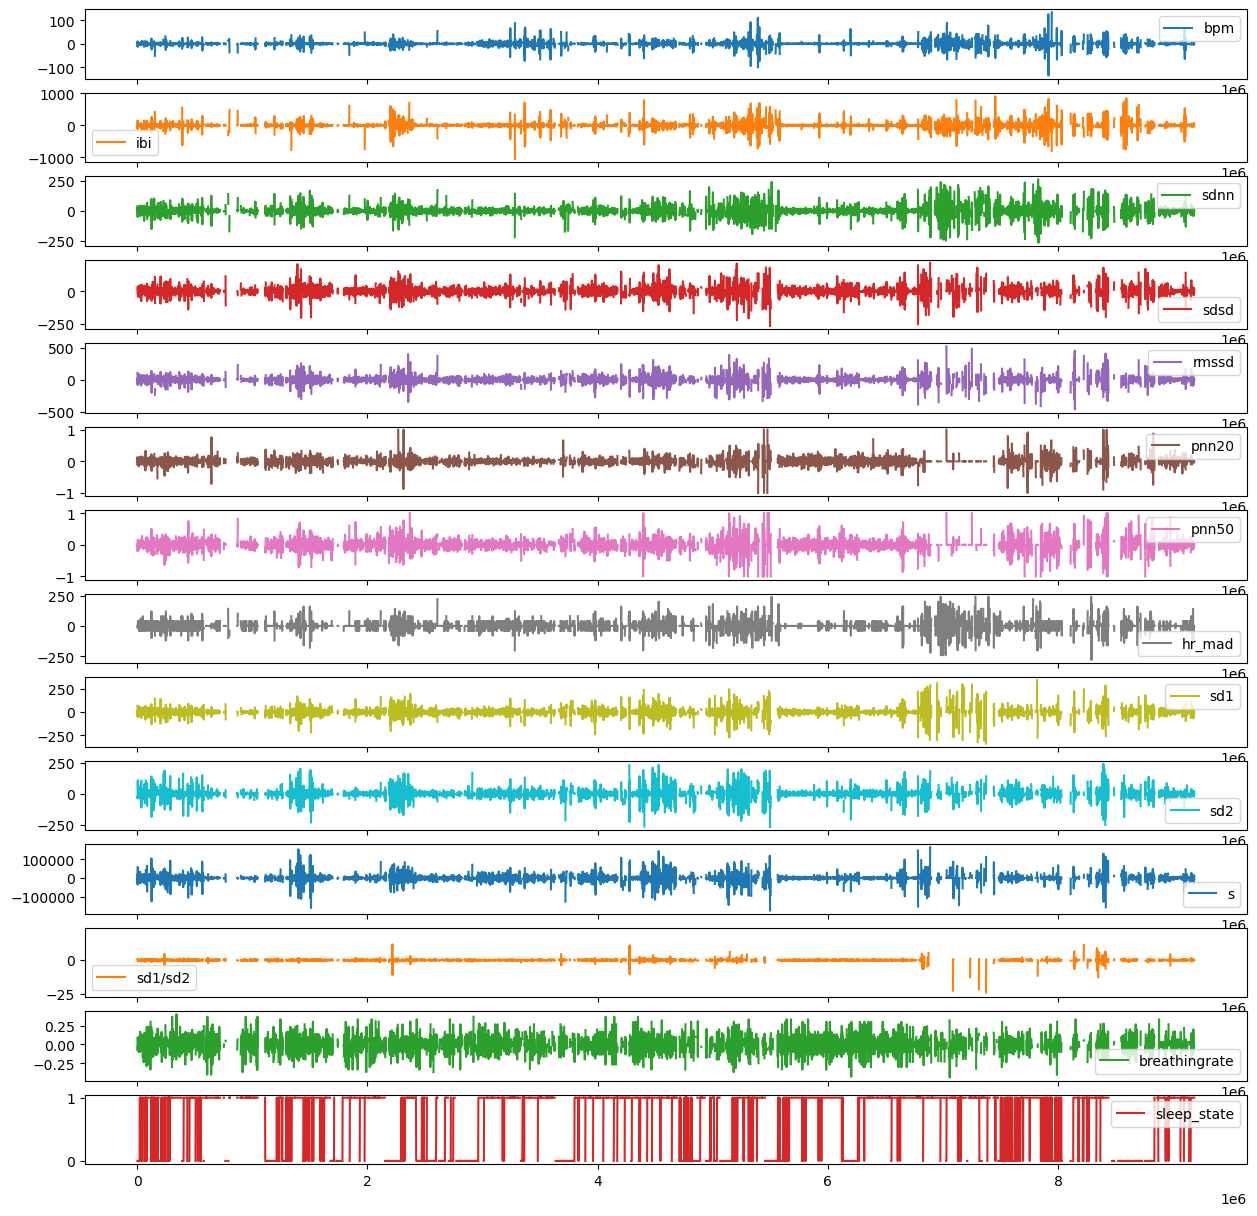

In [26]:
# subplots of all the columns
df_segmented.plot(subplots=True, figsize=(15, 15))

In [27]:
# drop the sleep_state column
ndf = df_segmented.drop(columns=['sleep_state'])

# drop the rows with class value as None
ndf = ndf.dropna()

# convert the class column to category 
ndf['class'] = ndf['class'].astype('category')

# # convert the class column to numeric
# ndf['class'] = ndf['class'].cat.codes

ndf

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,class
3000,8.691183,-93.517665,38.750477,28.849237,106.456111,0.117647,0.033613,0.0,69.248504,-24.436332,16624.775542,0.756443,0.086798,S
4500,-12.991882,148.881506,-50.457610,-17.734536,-77.592351,-0.125000,-0.200893,0.0,-48.487619,-38.968994,-35189.104693,0.169748,-0.080737,S
6000,9.002730,-108.643411,33.263879,-22.997263,27.472277,0.125000,0.161932,-20.0,19.215730,107.491638,58566.166580,-0.909088,-0.024565,S
13500,0.251507,-3.067788,2.989674,-19.943464,-3.816185,0.072917,0.083333,40.0,-2.917298,16.264387,4877.924300,-0.261392,0.033333,S
15000,-2.186321,27.425822,33.781790,42.060237,89.092459,0.055288,0.096154,40.0,63.140723,3.518592,21273.090250,0.585228,0.100000,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9174000,0.067143,-0.955882,8.975854,-19.593530,14.447891,0.036436,0.072872,0.0,10.718499,5.834294,7474.838076,0.005847,0.200000,W
9175500,-0.436510,6.250000,-1.934486,10.065620,4.863837,0.014202,0.028404,0.0,3.435650,-5.534784,-2316.112017,0.115984,0.000000,W
9177000,1.245875,-17.619048,2.804820,1.755980,-14.602808,-0.031636,-0.112453,-40.0,-10.339380,20.770429,9139.328607,-0.366050,-0.100000,W
9178500,-4.805829,71.932773,-39.695609,-29.469112,-68.257610,-0.037776,-0.026372,0.0,-48.414874,-25.211644,-31859.762512,-0.104389,0.000000,W


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

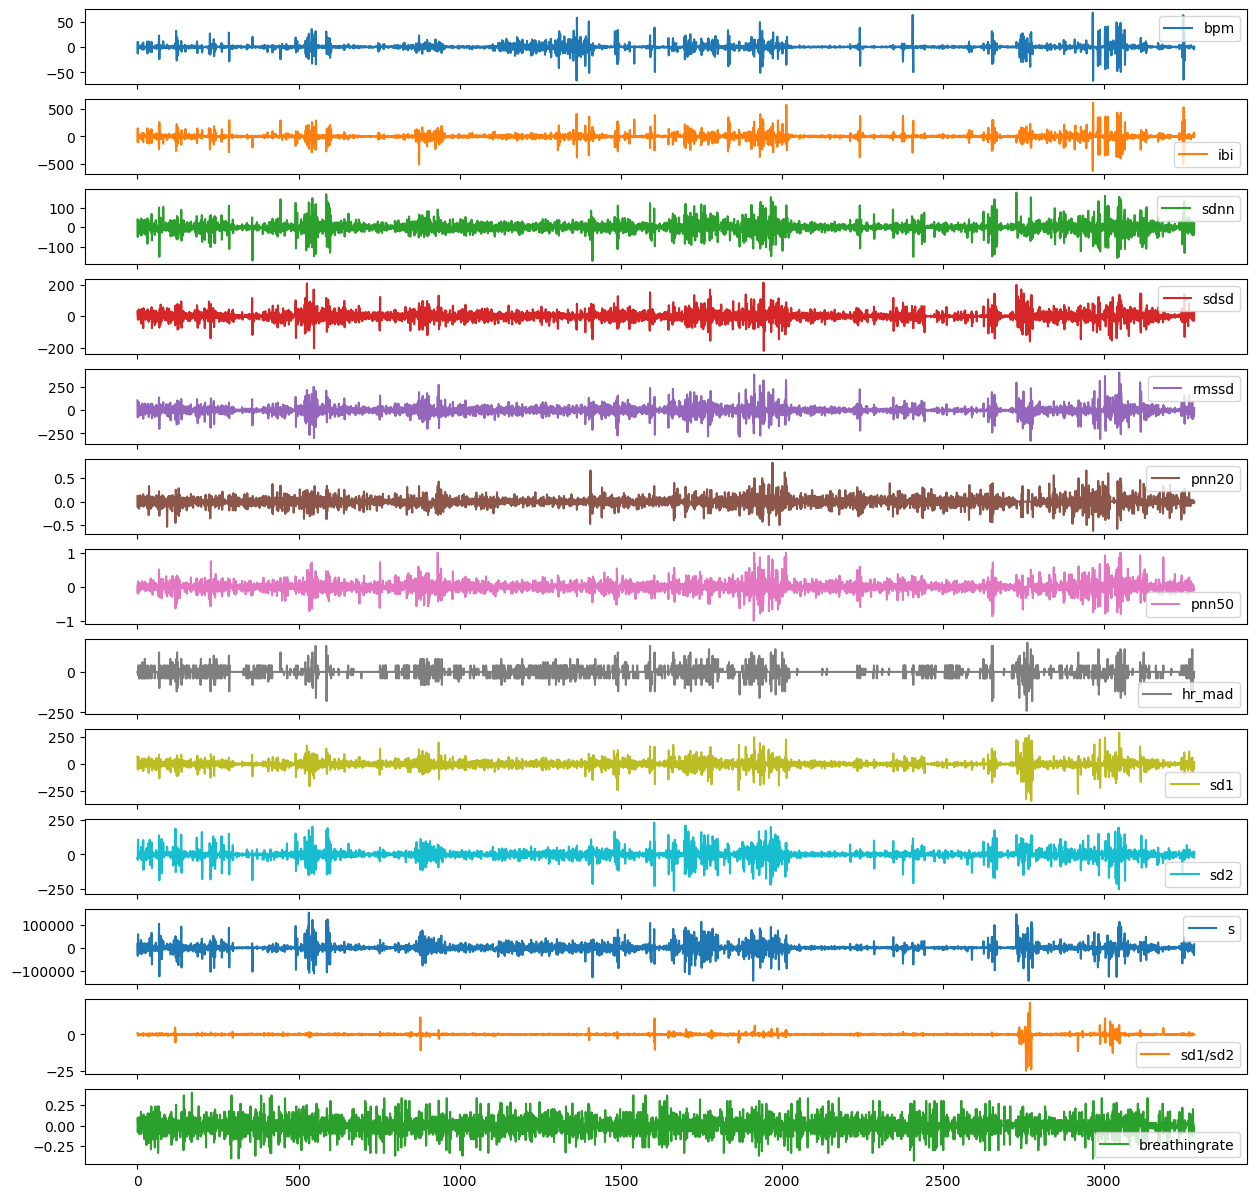

In [28]:
# plot ndf with class column
ndf.reset_index(drop=True).plot(subplots=True, figsize=(15, 15))


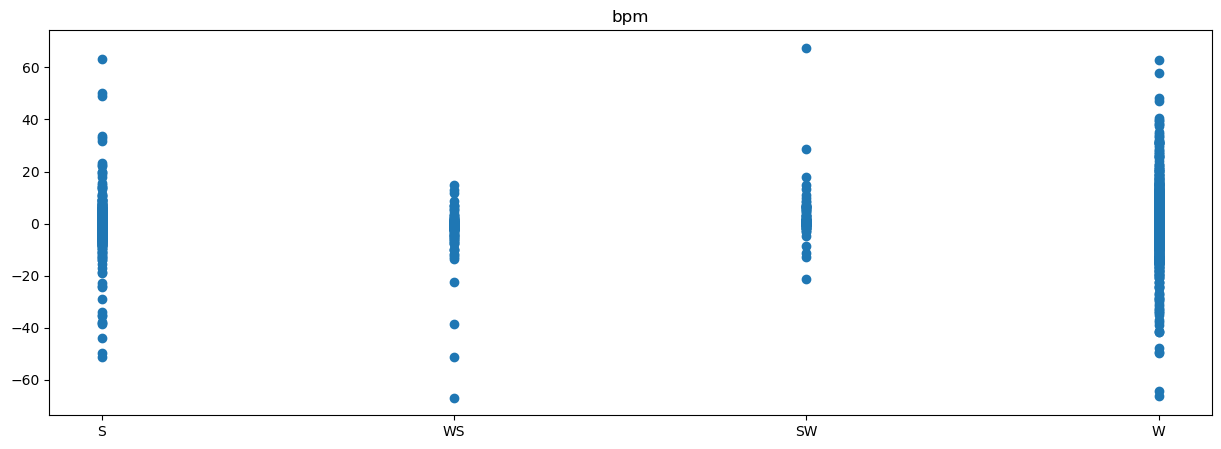

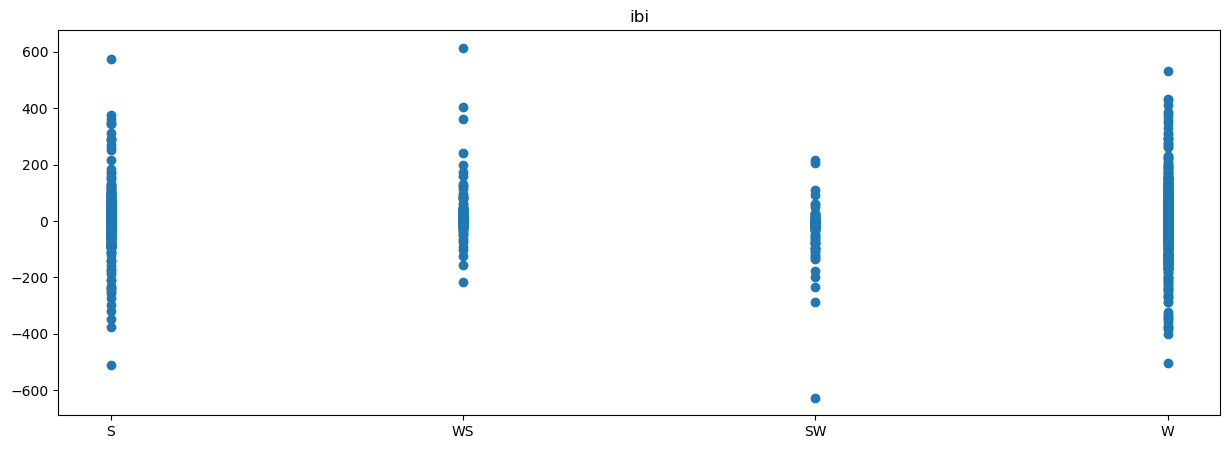

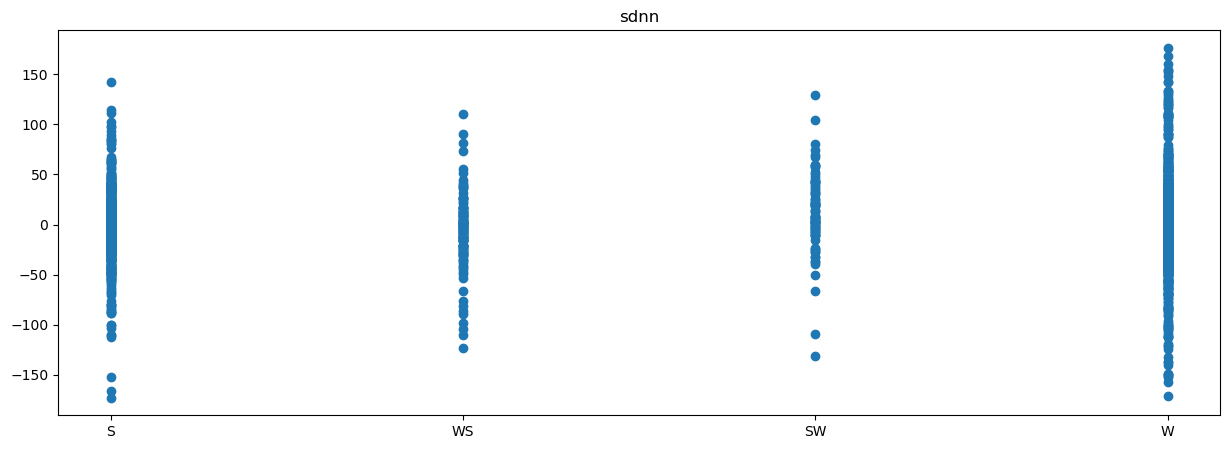

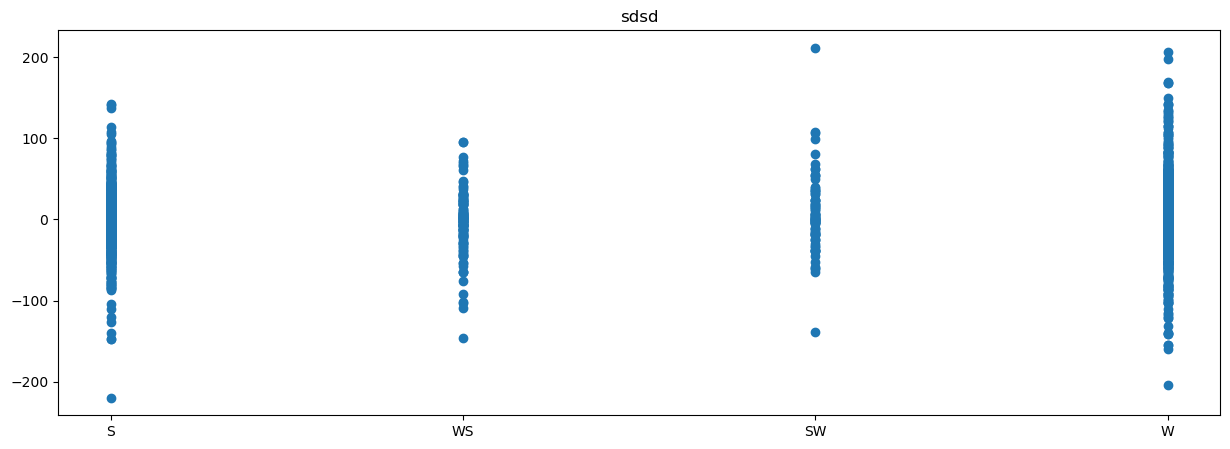

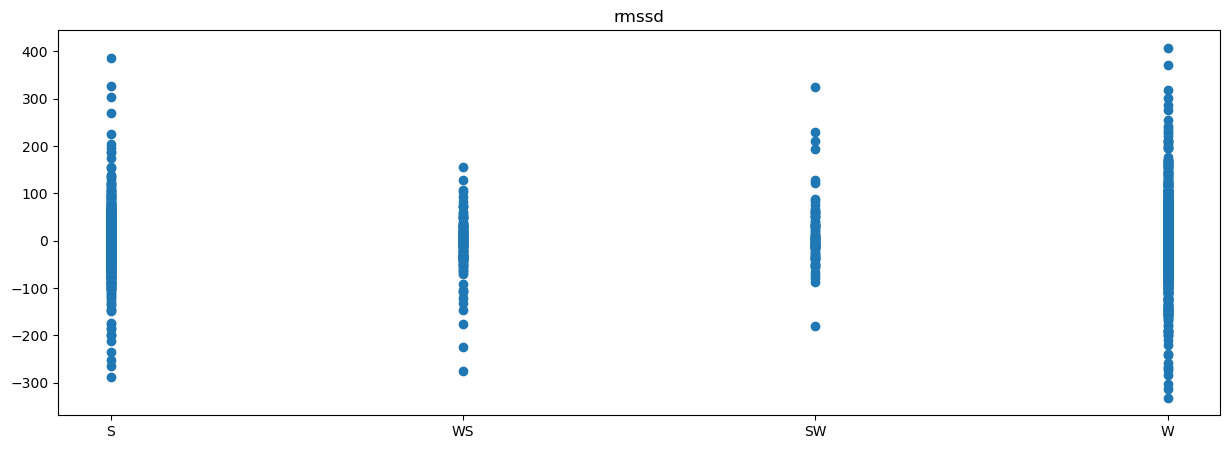

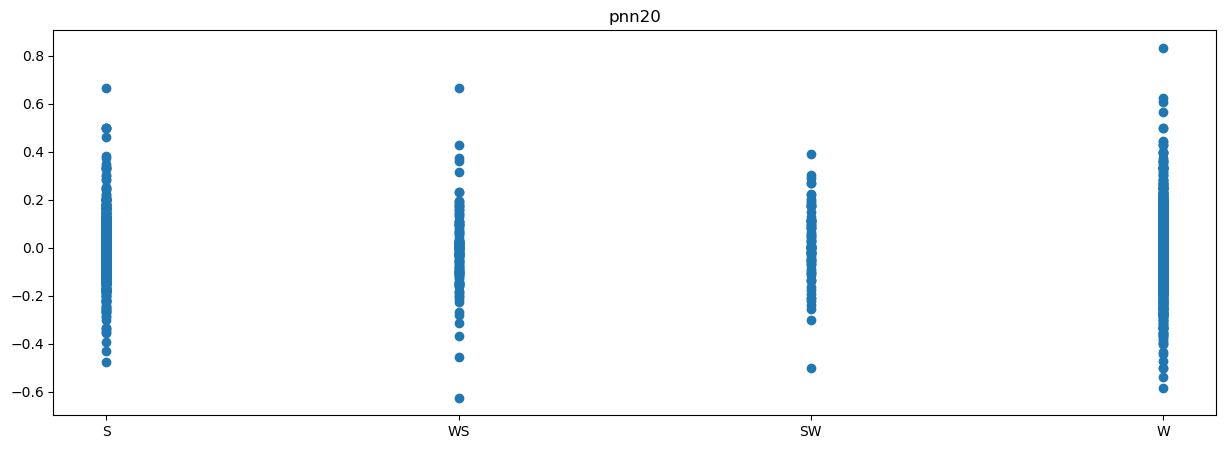

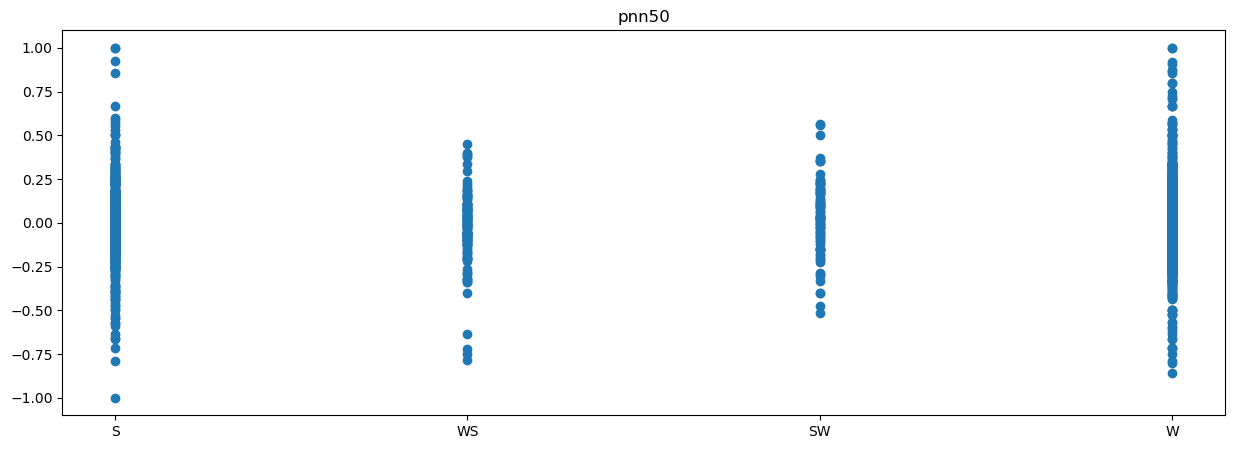

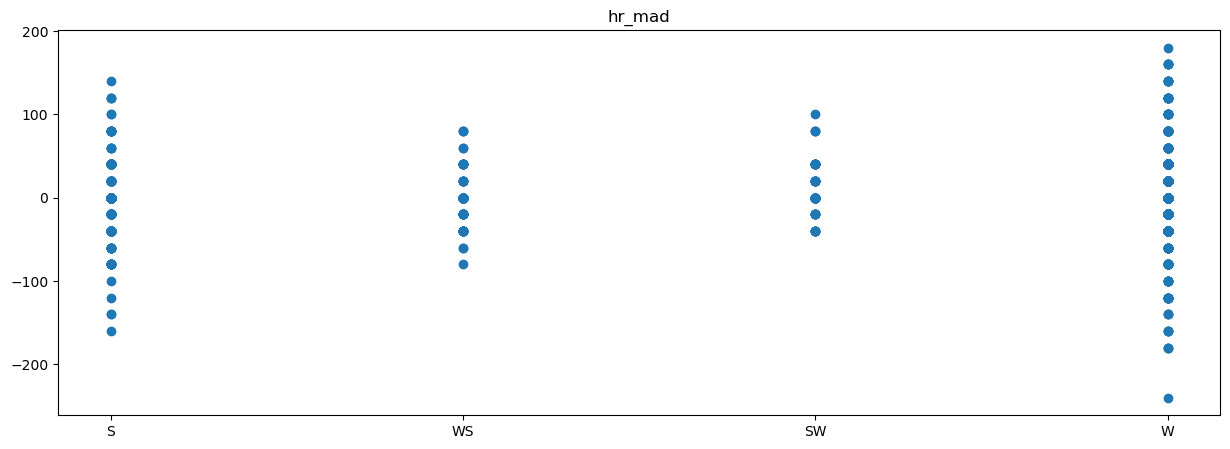

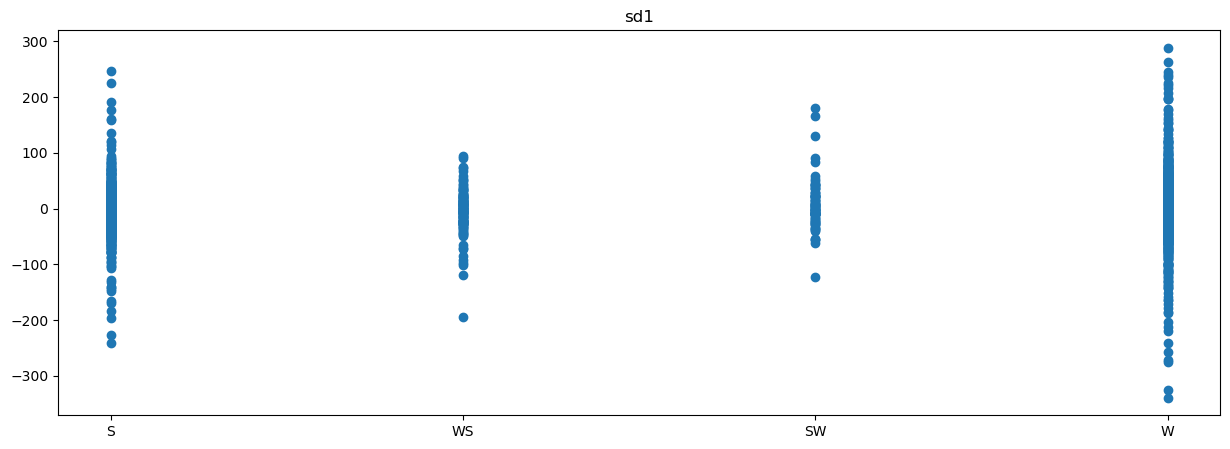

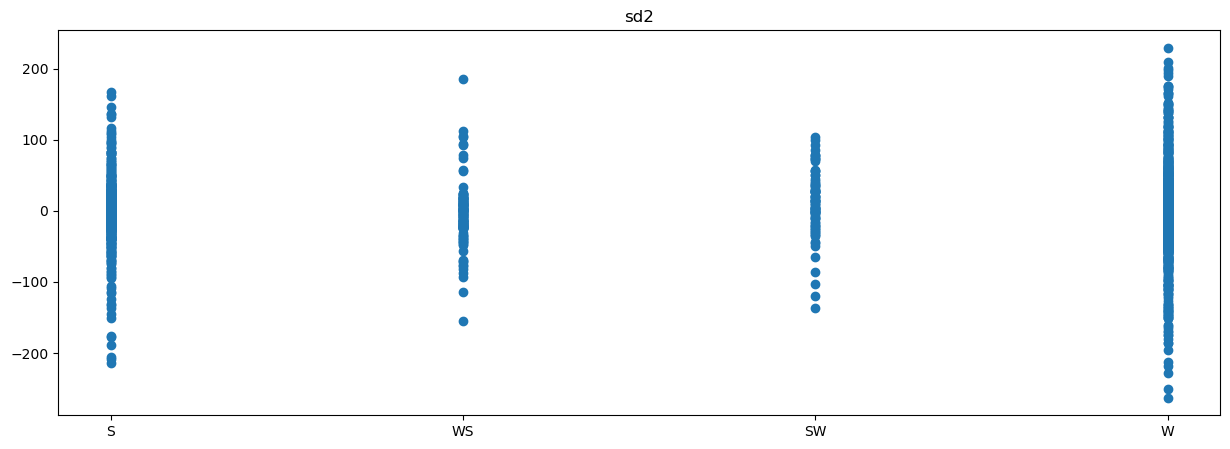

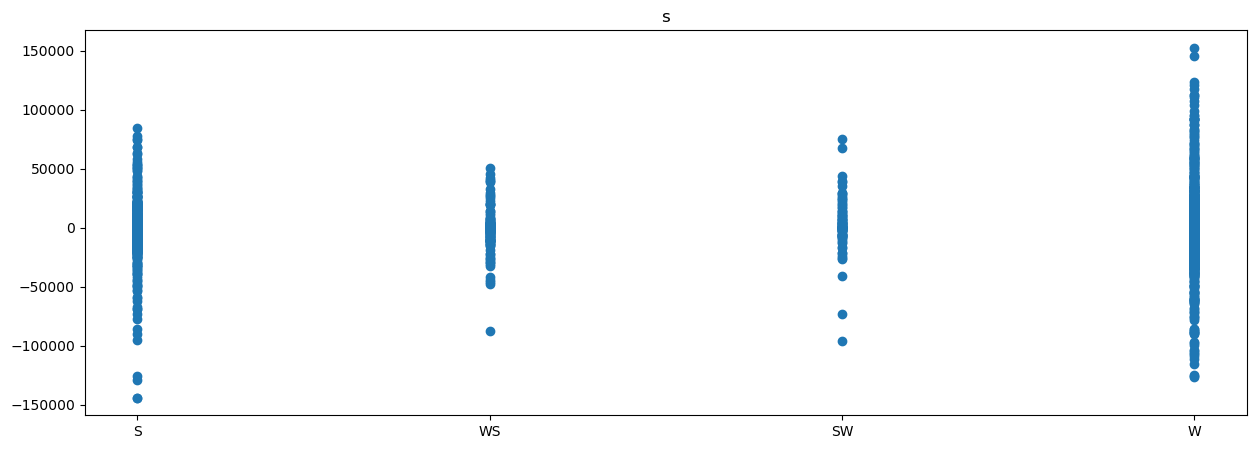

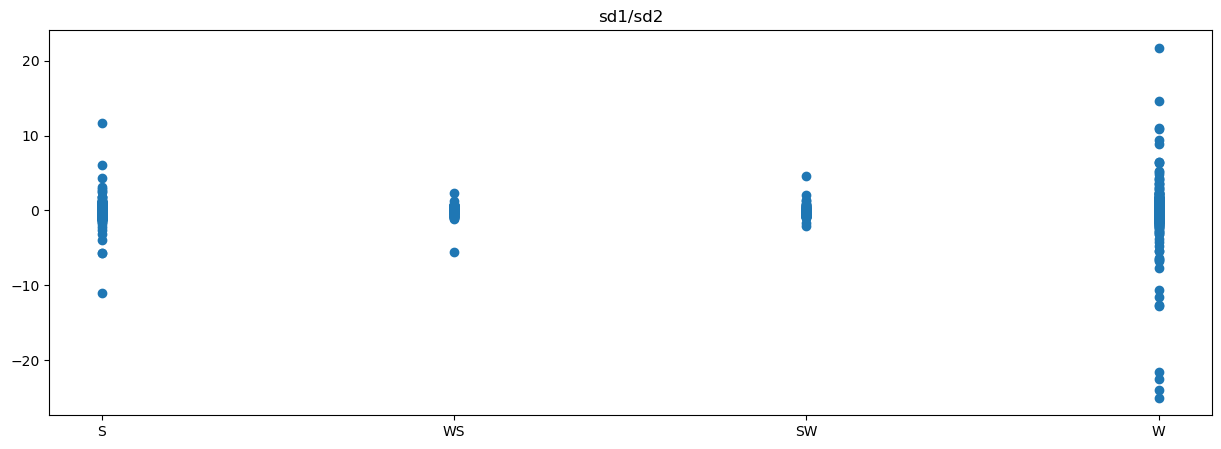

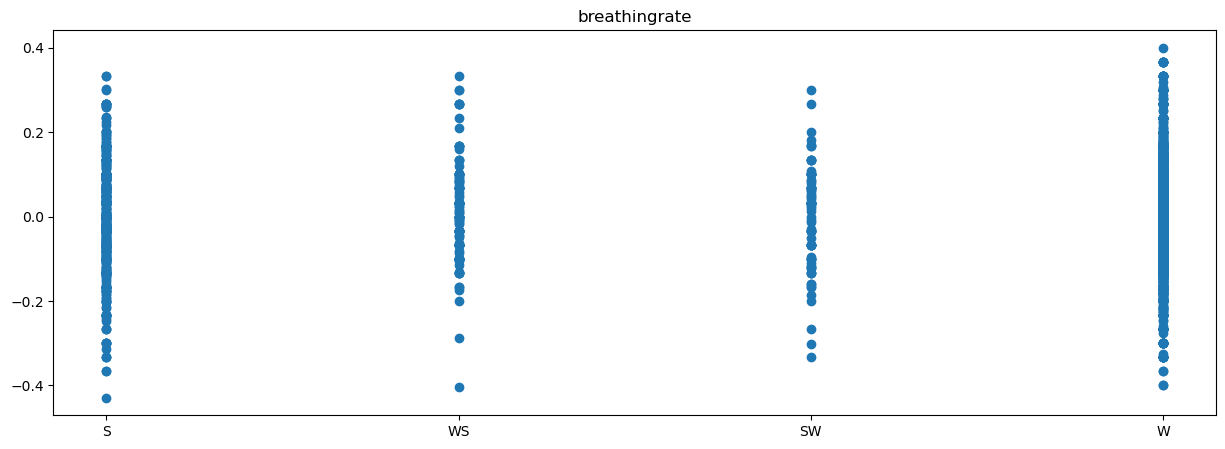

In [29]:
# plot as X axis - Class and Y-Axis the feature value for each feature

for i in range(0, len(ndf.columns) - 1):
    plt.figure(figsize=(15, 5))
    plt.scatter(ndf['class'], ndf.iloc[:, i])
    plt.title(ndf.columns[i])
    plt.show()